# Augmentation of Face Mask Detetection data
### Þórður Ágústsson
### tha100@hi.is

## Part 1 - Kaggle Data on GoogleColab

I Used this post as a guide for loading the data from Kaggle to GoogleColab: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676

Even though I used colab you could also use the same code (removing the ! from start of each line) to run the below notebook locally.

First we use pip to install the 'kaggle' package.

In [1]:
!pip install -q kaggle

Then we upload our kaggle.json file, which was previously downloaded from our kaggle account.

In [2]:
from google.colab import files
files.upload()

KeyboardInterrupt: ignored

So that the 'kaggle' package knows how to interact with kaggle we create a .kaggle directory and put our json file there.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset:

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

In [ ]:
!unzip face-mask-detection.zip -d data

## Part 2 - Preprocessing the data

In [1]:
from os import listdir
from google.colab.patches import cv2_imshow #Only necessary for GoogleColab, it does not allow cv2.imshow
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout 
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [2]:
def show_image(image, objects = False):
  """Prints out the image supplied.

    Parameters
    ----------
    image: numpy.ndarray
        The array representing the image.
    objects: dict, optional
        An array of dictionaries in the following format: 
        {"label":str, "box":{"xmin":int, "xmax":int, "ymin":int, "ymax":int}}.
        If supplied it is used to draw rectangles as specified by box with the "label" written above.

    Returns
    -------
    None
    """
  if(objects):
    for object in objects:
      image = cv2.rectangle(image, 
                      (object["box"]["xmin"], object["box"]["ymin"]), 
                      (object["box"]["xmax"], object["box"]["ymax"]), (36,255,12), 1)
      cv2.putText(image, object["label"], (object["box"]["xmin"], object["box"]["ymin"]-5)
      , cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12))
  # displaying image
  cv2_imshow(image)
  cv2.waitKey(0)
  plt.show()

def show_example(image_file_name, objects):
  """Prints out the cropped images of faces/masks found in 
    the image and also prints out the image itself with rectangles 
    drawn around the place of the cropped out images.

    Parameters
    ----------
    image_file_name: str
        The file name of the image (it has to be at "./data/images/") though.
    objects: dict
        An array of dictionaries in the following format: 
        {"label":str, "box":{"xmin":int, "xmax":int, "ymin":int, "ymax":int}}.
        It is used to draw rectangles as specified by box with the "label" written above.

    Returns
    -------
    None
    """
  image = cv2.imread(images_path + "/" + image_file_name)
  faces = [object for object in objects if object["image_file_name"] == image_file_name]
  for face in faces:
    cropped_image = image[
                            face["box"]["ymin"]:face["box"]["ymax"], 
                            face["box"]["xmin"]:face["box"]["xmax"]
                            ]
    cropped_image = cv2.resize(cropped_image, (125, 125))
    show_image(cropped_image)
  show_image(image, faces)

In [3]:
images_path = './data/images'
annotations_path = './data/annotations'
def get_file_paths():
  """Gets all the data-files needed. Both the annotations as xml files for the labels and images as .jpg files.

    Parameters
    ----------
    None

    Returns
    -------
    list(str)
      A list of the image file names.
    list(str)
      A list of the annotation file names.
    """
  #Sorted so we can be sure the image-annotation pairs are correct. 
  image_files = sorted(listdir(images_path))
  annotation_files = sorted(listdir(annotations_path))
  return image_files,annotation_files


def parse_object(object, image_file_name):
  """Parses an annotation object representing a face/mask in an image.

    Parameters
    ----------
    object: xml.etree.ElementTree.Element
      The object representing the face/mask, an Element from a xml file.
    
    image_file_name: str
      The name of the image_file this object is a part of.

    Returns
    -------
    dict:
      A dict representing this object in the following format:
        {
          "image_file_name":str,
          "label":str, 
          "box":
            {
              "xmin":int, 
              "xmax":int, 
              "ymin":int, 
              "ymax":int
              }
          } 
    """
  label = object.find('name')
  box = object.find('bndbox')
  data = {
      "image_file_name": image_file_name,
      "label": label.text,
      "box": {
          "xmin": int(box.find("xmin").text),
          "ymin": int(box.find("ymin").text),
          "xmax": int(box.find("xmax").text),
          "ymax": int(box.find("ymax").text)
      }
  }
  return data

def get_data(with_example = False):
  """Gets and returns the data a little tidier.

    Parameters
    ----------
    with_example: bool, optional
      If True it will print out the cropped images of faces/masks found on a single image
      and also the whole image with rectangles drawn around the faces/masks.

    Returns
    -------
    list(numpy.ndarray)
      A list of the images in array of numbers format.
    list(str)
      A list of labels: "with_mask", "without_mask" and "mask_weared_incorrect"
    list(dict)
      A list of dictionaries representing each object found in the following format: 
      {
          "image_file_name":str,
          "label":str, 
          "box":
            {
              "xmin":int, 
              "xmax":int, 
              "ymin":int, 
              "ymax":int
              }
          } 
    """
  image_files,annotation_files = get_file_paths()
  objects = [] #Array of dicts representing each face-object on images.
  labels = [] #string array with labels
  images = [] #Array of numpy-image-arrays
  image_dim = 100 #Dimensions of the final images.
  for annotation_file_path in tqdm(annotation_files):
    root = ET.parse(annotations_path + "/" + annotation_file_path).getroot()
    image_file_name = root.find("filename").text
    for object in root.iter("object"):
      parsed_ob = parse_object(object,image_file_name)
      objects.append(parsed_ob)
      labels.append(parsed_ob["label"])
      image = cv2.imread(images_path + "/" + image_file_name)
      cropped_image = image[
                            parsed_ob["box"]["ymin"]:parsed_ob["box"]["ymax"], 
                            parsed_ob["box"]["xmin"]:parsed_ob["box"]["xmax"]
                            ]
      cropped_image = cv2.resize(cropped_image, (image_dim, image_dim))
      images.append(np.array(cropped_image))
  
  if(with_example):
    show_example(image_files[0],objects)
  return images,labels,objects

Retrieving the data from files:

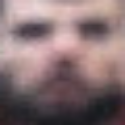

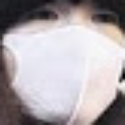

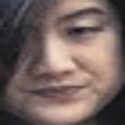

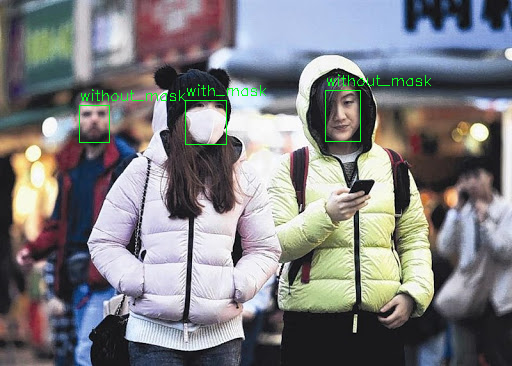

In [4]:
images,labels,objects = get_data(with_example = True)

In [5]:
def prepare_inputs(X):
  """Changes the list of numpy.ndarray of values between 0 and 255 into
    a numpy array of numpy arrays (i.e. a matrix of images) with numbers
    between 0.0 and 1.0.

    Parameters
    ----------
    X: list(numpy.ndarray)
      A list of numpy.ndarray-encoded images.

    Returns
    -------
    numpy.ndarray
      A matrix of numpy.ndarrays with numbers between 0.0 and 1.0
    """
    X = np.array(X)
    X = X/255 
    return X

def prepare_targets(y):
    """Changes the class-labels from string to a one-hot-encoding.

    Parameters
    ----------
    y: list(str)
      Changes this list of string into a list of one-hot-encodings.

    Returns
    -------
    list(numpy.ndarray)
      A list of one-hot-encodings.

    sklearn.preprocessing._label.LabelEncoder
      The encoder.
    """
    le = LabelEncoder()
    le.fit(y)
    y_int = le.transform(y)
    y_one_hot = to_categorical(y_int, 3)
    return y_one_hot,le

Preparing the data and splitting into test/training sets.

In [28]:
X = prepare_inputs(images)
y,encoder = prepare_targets(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Part 3 - Training model on non-augmented images

Define model:

In [7]:
def plot_model_performance(history):
  """Plots the history of the model-training.

    Parameters
    ----------
    history: list(str)
      Changes this list of string into a list of one-hot-encodings.

    Returns
    -------
    list(numpy.ndarray)
      A list of one-hot-encodings.
  """
  print(type(history))
  fig = plt.figure(figsize = (20,20))
  #plot accuracy
  plt.subplot(221)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train','test'],loc ="upper left")

  #plot loss 
  plt.subplot(222)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model_loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train','test'],loc ="upper left")
  plt.show()

In [8]:
def model_definition(image_dim, verbose = False):
  """Defines and returns a newly compiled model.

    Parameters
    ----------
    image_dim: int
      dimensions of the image (assumes same width/height for image data)
    verbose: bool, optional
      If True it prints out the summary of the model.

    Returns
    -------
    keras.model
  """
  
  model = Sequential()
  model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = 'relu',padding = 'same',input_shape = (image_dim,image_dim,3)))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(filters = 96,kernel_size = (3,3),activation = 'relu',padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(filters = 128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
  model.add(Conv2D(filters = 128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2,2)))


  model.add(Flatten())
  model.add(Dense(512,activation = 'relu'))
  model.add(Dense(3,activation = "softmax"))
  if(verbose):
    model.summary()
  opt = Adam(lr=0.000001)
  model.compile(optimizer = opt , loss = "categorical_crossentropy" , metrics = ['accuracy'])   
  return model

Train model without Augmented images:

Epoch 1/100
82/82 [==============================] - 10s 32ms/step - loss: 1.0625 - accuracy: 0.4509 - val_loss: 0.8630 - val_accuracy: 0.8267
Epoch 2/100
82/82 [==============================] - 2s 25ms/step - loss: 0.8205 - accuracy: 0.7979 - val_loss: 0.6506 - val_accuracy: 0.8267
Epoch 3/100
82/82 [==============================] - 2s 26ms/step - loss: 0.6581 - accuracy: 0.7909 - val_loss: 0.5584 - val_accuracy: 0.8267
Epoch 4/100
82/82 [==============================] - 2s 25ms/step - loss: 0.5936 - accuracy: 0.7892 - val_loss: 0.5251 - val_accuracy: 0.8267
Epoch 5/100
82/82 [==============================] - 2s 25ms/step - loss: 0.5654 - accuracy: 0.7918 - val_loss: 0.5060 - val_accuracy: 0.8267
Epoch 6/100
82/82 [==============================] - 2s 25ms/step - loss: 0.5504 - accuracy: 0.7890 - val_loss: 0.4873 - val_accuracy: 0.8267
Epoch 7/100
82/82 [==============================] - 2s 25ms/step - loss: 0.5459 - accuracy: 0.7850 - val_loss: 0.4705 - val_accuracy: 0.8267
Epoch

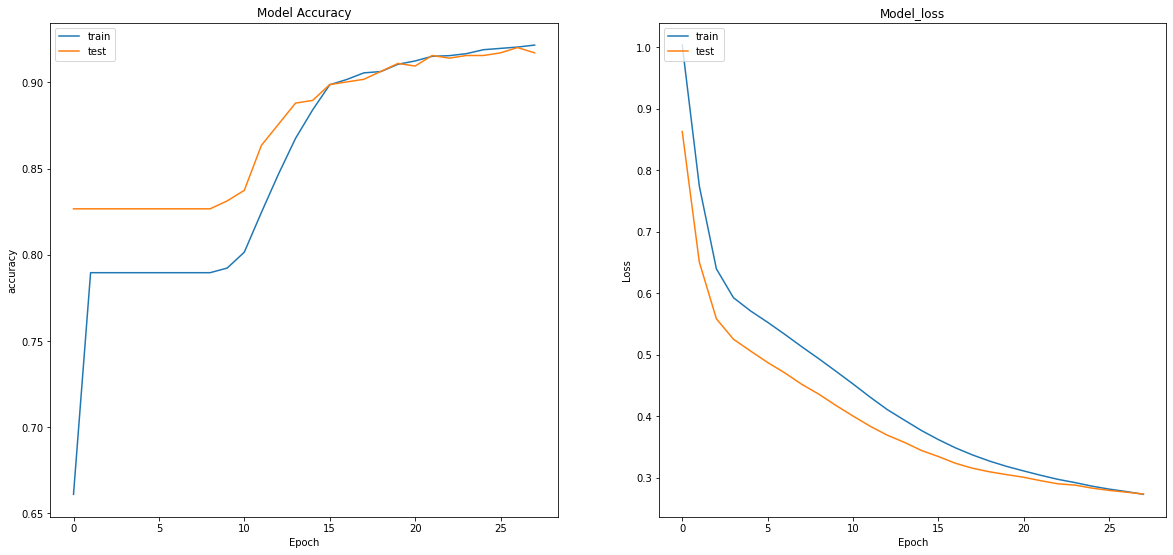

In [9]:
epochs = 100
model = model_definition(X_train[0].shape[1])
acc_stopper = EarlyStopping(monitor = 'val_loss',patience = 5,verbose = 1,min_delta = 0.01) 
history = model.fit(X_train,y_train,epochs = epochs,validation_split = 0.2, callbacks=[acc_stopper])
plot_model_performance(history)

Evaluating the model on the test set:

In [10]:
scores = model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 10ms/step - loss: 0.2706 - accuracy: 0.9141


## Part 4 - Training model on data with Augmented images



Creating the generator that generates new images from our training data:

In [11]:
#Wanted to use "brightness_range", but it fucked the images up. Made them all white. Too white. Or too Bright. So I
#skipped it and used only variations of the images that showed some visual differences that "made sense"
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.1,
    channel_shift_range=0.2,
    )
datagen.fit(X_train)

In [12]:
def augmentation_example(image,datagen,nr_augments = 10):
  """Prints out 5 columns of images. The image supplied first
  and the nr_augments number of augmentated images of the original image after the original one.

    Parameters
    ----------
    image: numpy.ndarray
      The image to use to create more data
    datagen: tensorflow.python.keras.preprocessing.image.ImageDataGenerator
      Fitted on the training data
    nr_augments:
      nr of augments to create and display of the original image.

    Returns
    -------
    None
  """
  columns = 5

  plt.figure(figsize=(20,10))
  plt.subplot(nr_augments / columns + 1, columns, 1)
  plt.imshow((image*255).astype(np.uint8))
  
  i = 0
  for x_batch in datagen.flow(
      np.array([image]),batch_size=1):
      for j in range(1):
        plt.subplot(nr_augments / columns + 1, columns, i + 2)
        plt.imshow((x_batch[j]*255).astype(np.uint8))
      i+=1
      if(i == nr_augments):
        break

Visualizing what the Augmentation pakage does:

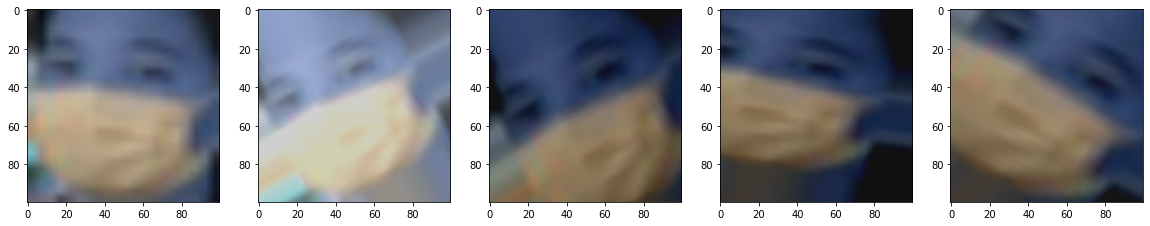

In [13]:
augmentation_example(X_train[25],datagen,nr_augments=4)

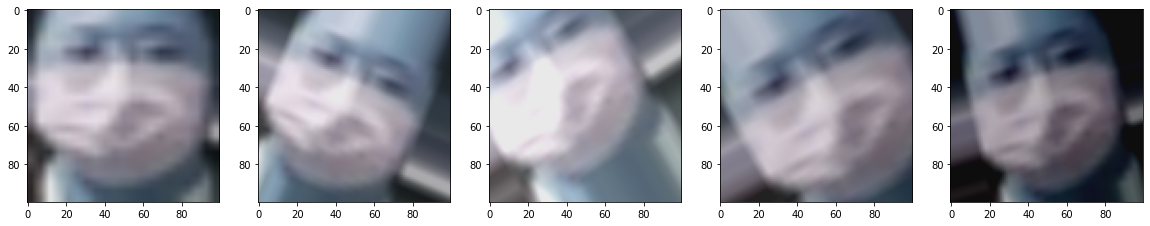

In [14]:
augmentation_example(X_train[251],datagen,nr_augments=4)

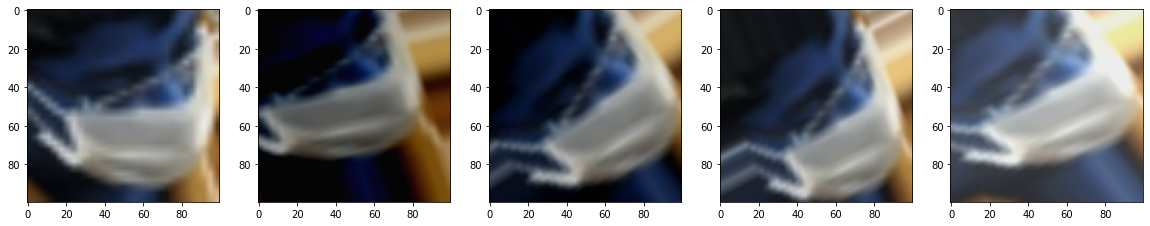

In [15]:
augmentation_example(X_train[451],datagen,nr_augments=4)

Create 2 times as many images as in the original training dataset and append those to the original dataset.

In [16]:
def create_data_from(X,y, datagen, prop = 0.1):
  """Creates more images from the set of X-images supplied to this func.

    Parameters
    ----------
    X: numpy.ndarray
      A matrix of numpy.ndarray encoded images.
    y: numpy.ndarray
      A list of labels corresponding to the data from the X matrix
    datagen: tensorflow.python.keras.preprocessing.image.ImageDataGenerator
      Fitted on the training data
    prop: float, optional
      How many more images to create. 0.1 is 10% more.

    Returns
    -------
    numpy.ndarray
      The X-matrix with the augmented data appended to the end.

    numpy.ndarray
      The y-labels with the augmented data-labels appended to the end.
  """
  augment_size = int(X.shape[0]*prop)
  X_aug = np.copy(X)
  y_aug = np.copy(y)
  i = 0
  batch_size = augment_size

  if(augment_size > X.shape[0]):
    batch_size = X.shape[0]
  for x_batch, y_batch in tqdm(datagen.flow(
      X, y, batch_size=batch_size)):
      X_aug = np.append(X_aug, x_batch,axis=0)
      y_aug = np.append(y_aug, y_batch,axis=0)
      i += batch_size
      if(i >= augment_size):
        break
  return X_aug, y_aug

Train the model on the dataset twice the data (Augmented data 50%):

Epoch 1/100

163/163 [==============================] - 5s 28ms/step - loss: 0.9191 - accuracy: 0.7950 - val_loss: 0.6344 - val_accuracy: 0.8081
Epoch 2/100
163/163 [==============================] - 4s 25ms/step - loss: 0.6215 - accuracy: 0.7933 - val_loss: 0.5592 - val_accuracy: 0.8081
Epoch 3/100
163/163 [==============================] - 4s 25ms/step - loss: 0.5618 - accuracy: 0.8008 - val_loss: 0.5354 - val_accuracy: 0.8081
Epoch 4/100
163/163 [==============================] - 4s 25ms/step - loss: 0.5315 - accuracy: 0.7923 - val_loss: 0.5085 - val_accuracy: 0.8081
Epoch 5/100
163/163 [==============================] - 4s 25ms/step - loss: 0.5157 - accuracy: 0.7903 - val_loss: 0.4761 - val_accuracy: 0.8081
Epoch 6/100
163/163 [==============================] - 4s 25ms/step - loss: 0.4684 - accuracy: 0.7984 - val_loss: 0.4393 - val_accuracy: 0.8173
Epoch 7/100
163/163 [==============================] - 4s 25ms/step - loss: 0.4336 - accuracy: 0.8210 - val_loss: 0.4018 - val_accuracy

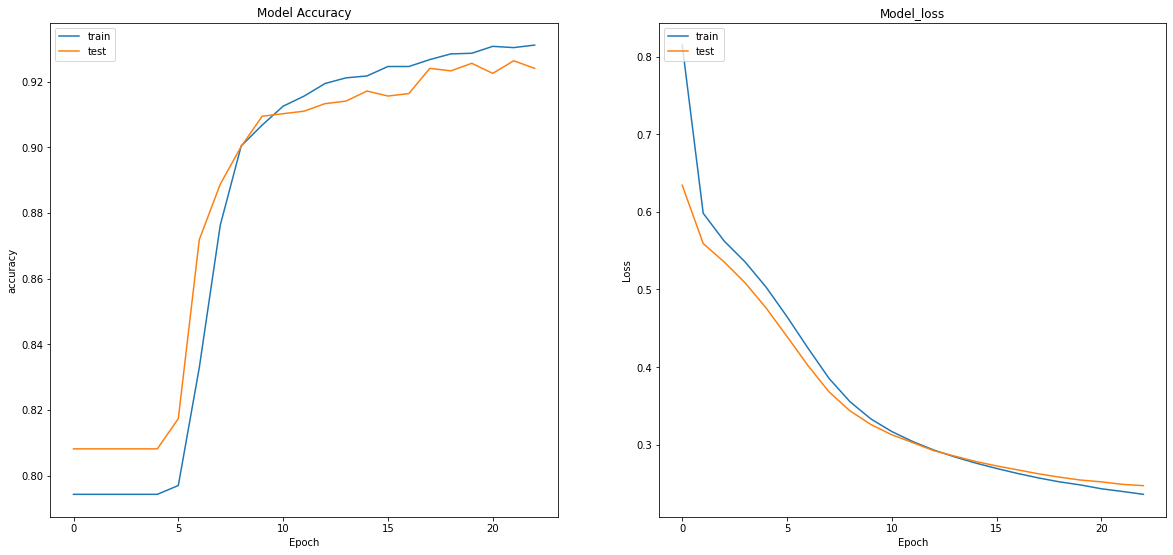

In [17]:
X_train_aug, y_train_aug = create_data_from(X_train, y_train,datagen, prop=1)
model = model_definition(image_dim=X_train_aug[0].shape[1])
history = model.fit(X_train_aug,y_train_aug,epochs = epochs,validation_split = 0.2, callbacks=[acc_stopper])
plot_model_performance(history)

In [18]:
scores = model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 8ms/step - loss: 0.2188 - accuracy: 0.9337


A minor improvement. But still. An improvement.

## Part 5 - Training model on data with Augmented images and Oversampling of wrong mask wearers

Finally we will try and improve upon our original non-augmented model by looking at imbalances in our data.

How the label-encoder encoded our data: (though we did not just run our labels through the encoder but also from the encoder through a to_categorical function)

In [19]:
encoder.inverse_transform([0,1,2])

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [20]:
incorrect_wearing = [1.0,0.0,0.0]
with_mask = [0.0,1.0,0.0]
without_mask = [0.0,0.0,1.0]
nr_incorrect_wearing = np.where(np.all(y_train==incorrect_wearing,axis=1))[0].shape[0]
nr_with_mask = np.where(np.all(y_train==with_mask,axis=1))[0].shape[0]
nr_without_mask = np.where(np.all(y_train==without_mask,axis=1))[0].shape[0]
print(f"Datapoints in training set of people wearing their masks incorrectly: {nr_incorrect_wearing}")
print(f"Datapoints in training set of people wearing masks: {nr_with_mask}")
print(f"Datapoints in training set of people not wearing masks: {nr_without_mask}")

Datapoints in training set of people wearing their masks incorrectly: 102
Datapoints in training set of people wearing masks: 2596
Datapoints in training set of people not wearing masks: 559


From this we think to ourselves that we can maybe get a higher accuracy by creating more samples in our training data of people wearing their masks incorrectly and not wearing masks at all.

In [29]:
X_train_incorrect_wearing = X_train[np.where(np.all(y_train==incorrect_wearing,axis=1))]
X_train_non_wearing = X_train[np.where(np.all(y_train==without_mask,axis=1))]
X_train_wearing = X_train[np.where(np.all(y_train==with_mask,axis=1))]

y_train_incorrect_wearing = y_train[np.where(np.all(y_train==incorrect_wearing,axis=1))]
y_train_non_wearing = y_train[np.where(np.all(y_train==without_mask,axis=1))]
y_train_wearing = y_train[np.where(np.all(y_train==with_mask,axis=1))]

In [30]:
X_train_incorrect_wearing,y_train_incorrect_wearing = create_data_from(
    X_train_incorrect_wearing, 
    y_train_incorrect_wearing, 
    datagen,
    6)
X_train_non_wearing,y_train_non_wearing = create_data_from(
    X_train_non_wearing, 
    y_train_non_wearing, 
    datagen,
    3)
X_train_wearing,y_train_wearing = create_data_from(
    X_train_wearing, 
    y_train_wearing, 
    datagen,
    1)

In [31]:
X_train_imbalances_improved = np.append(X_train_wearing, X_train_incorrect_wearing, axis=0)
X_train_imbalances_improved = np.append(X_train_imbalances_improved, X_train_non_wearing, axis=0)

y_train_imbalances_improved = np.append(y_train_wearing, y_train_incorrect_wearing, axis=0)
y_train_imbalances_improved = np.append(y_train_imbalances_improved, y_train_non_wearing, axis=0)

Free up some RAM:

In [35]:
del X_train
del X_train_aug
del y_train
del y_train_aug
del X_train_wearing
del y_train_wearing
del X_train_incorrect_wearing
del y_train_incorrect_wearing
del X_train_non_wearing
del y_train_non_wearing
del model
del history
del X
del y

In [39]:
acc_stopper = EarlyStopping(monitor = 'val_loss',patience = 5,verbose = 1,min_delta = 0.01) 

Epoch 1/100
204/204 [==============================] - 6s 27ms/step - loss: 0.9237 - accuracy: 0.7935 - val_loss: 1.8837 - val_accuracy: 0.0000e+00
Epoch 2/100
204/204 [==============================] - 5s 25ms/step - loss: 0.6582 - accuracy: 0.7981 - val_loss: 2.1751 - val_accuracy: 0.0000e+00
Epoch 3/100
204/204 [==============================] - 5s 25ms/step - loss: 0.6334 - accuracy: 0.8030 - val_loss: 2.1490 - val_accuracy: 0.0000e+00
Epoch 4/100
204/204 [==============================] - 5s 25ms/step - loss: 0.6391 - accuracy: 0.7947 - val_loss: 2.1040 - val_accuracy: 0.0000e+00
Epoch 5/100
204/204 [==============================] - 5s 25ms/step - loss: 0.6018 - accuracy: 0.8044 - val_loss: 1.9741 - val_accuracy: 0.0000e+00
Epoch 6/100
204/204 [==============================] - 5s 25ms/step - loss: 0.5910 - accuracy: 0.7995 - val_loss: 1.8648 - val_accuracy: 0.0000e+00
Epoch 7/100
204/204 [==============================] - 5s 25ms/step - loss: 0.5592 - accuracy: 0.8028 - val_loss

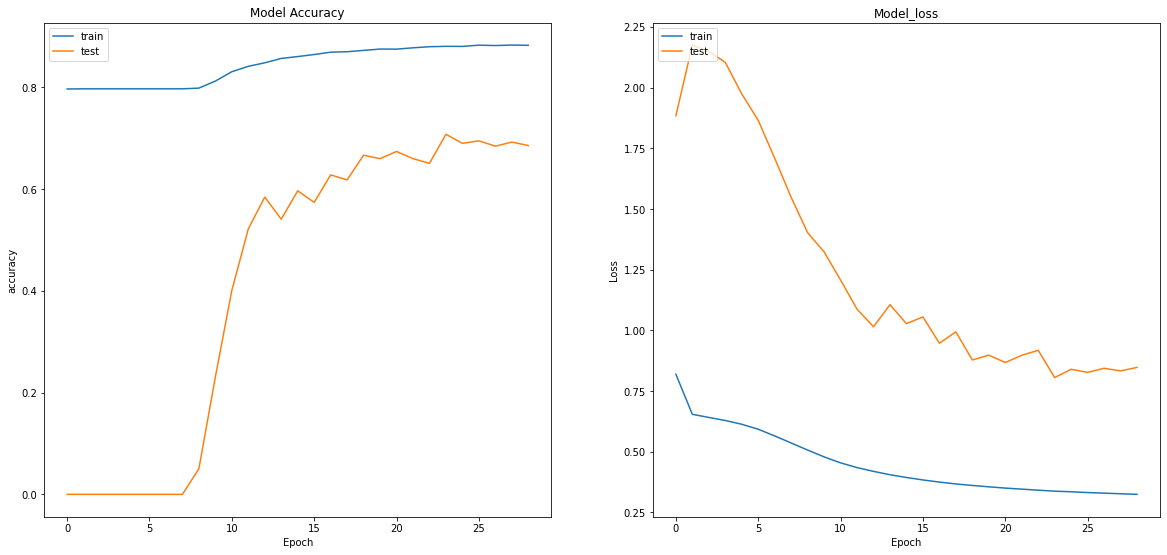

In [44]:
model = model_definition(image_dim=X_train_imbalances_improved[0].shape[1])
history = model.fit(
    X_train_imbalances_improved,
    y_train_imbalances_improved,
    shuffle=True,
    epochs = epochs,
    validation_split = 0.2, 
    callbacks=[acc_stopper])
plot_model_performance(history)

In [45]:
scores = model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 10ms/step - loss: 0.2489 - accuracy: 0.9215


We can see that this first test of choosing to augment more towards the imbalanced data does not improve our accuracy. But maybe with tuning of hyperparameters this accuracy can be improved.

This notebook was a huge help for this project: https://www.kaggle.com/prekshabhavsar/face-mask-detection-with-92-accuracy

### Single Comment at a later date

Would be interesting to see a confusion matrix.